In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
# This line disables GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import numpy as np
import time

print('Import successful.')

2025-11-10 17:17:08.399981: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Import successful.


Initial settings

In [2]:
batch_size = 64   # Amount of the pictures passed at parallel. 50 000 pictures / 64 is approx 781 batches
num_classes = 10  # CIFAR has 10 classes
epochs = 50       # Amount of data repeats
input_shape = (32, 32, 3) # CIFAR-10 picturies size (high, width, RGB)

# CIFAR-10 class names for the analysis
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

Data preparation / fetching

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# From unit8 to float32 + normalization
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f'x_train shape: {x_train.shape}') # Have to be: (50000, 32, 32, 3)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples \n")

# One-Hot-Encoded 5 -> [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
# print(y_train[:5])
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train[:3])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples 

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


Building CNN; we used double convolutional layers due to AI suggestion.

In [4]:
model = Sequential()

# Convolutional block 1
# Input Layer (32x32x3)
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
#32 kernels applied + zero padding to prevent boborder information loss
model.add(BatchNormalization()) # Add on for cognitive benefits
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3)) # Add on to prevent overfitting

# Convolutional block 2
model.add(Conv2D(64, (3, 3), padding='same', activation='relu')) #64 kernels applied
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# FCN-part
model.add(Flatten()) # Litistetään (Flatten) data, esim. (8, 8, 64) -> 4096 piirrettä
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # Korkeampi Dropout-arvo tässä, koska Dense-kerrokset ovat alttiimpia ylioppimiselle.
model.add(Dense(num_classes, activation='softmax'))

print("\n--- Model Info ---")
model.summary()

/home/pavel/miniconda3/envs/keras_gpu/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762787832.976865   12204 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4978 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9



--- Model Info ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251,242 (4.77 MB)

 Trainable params: 1,251,050 (4.77 MB)

 Non-trainable params: 192 (768.00 B)

Model compile / train / evaluation

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


print("\n--- Training the Model ---")
start_time = time.time()

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

train_time = time.time() - start_time

score = model.evaluate(x_test, y_test, verbose=0)
print(f'\nTest loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]*100:.2f}')
print("Training time (s):", train_time)
print("Parameters:", model.count_params())
print("Epochs:", epochs)


--- Training the Model ---


2025-11-10 17:17:21.467706: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 614400000 exceeds 10% of free system memory.
2025-11-10 17:17:22.728632: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/50


2025-11-10 17:17:24.576530: I external/local_xla/xla/service/service.cc:163] XLA service 0x752134012800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-10 17:17:24.576561: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-11-10 17:17:24.615440: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-10 17:17:24.890863: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


 20/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1223 - loss: 4.2840

I0000 00:00:1762787849.258755   12303 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3115 - loss: 2.0064

2025-11-10 17:17:36.549080: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_181', 4 bytes spill stores, 4 bytes spill loads

2025-11-10 17:17:38.003841: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_181', 4 bytes spill stores, 4 bytes spill loads



782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.3981 - loss: 1.6646 - val_accuracy: 0.5547 - val_loss: 1.2484
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5568 - loss: 1.2443 - val_accuracy: 0.5891 - val_loss: 1.1335
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6317 - loss: 1.0550 - val_accuracy: 0.6594 - val_loss: 0.9660
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6713 - loss: 0.9433 - val_accuracy: 0.6814 - val_loss: 0.9232
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6998 - loss: 0.8667 - val_accuracy: 0.7210 - val_loss: 0.8142
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7186 - loss: 0.8131 - val_accuracy: 0.7091 - val_loss: 0.8647
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7314 - loss: 0.7719 - val_accuracy: 0.7467 - val_loss: 0.7422
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7470 - loss: 0.7340 - val_accuracy: 0.7470 - va

2025-11-10 17:20:32.722627: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_181', 16 bytes spill stores, 16 bytes spill loads

2025-11-10 17:20:32.752143: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_181', 4 bytes spill stores, 4 bytes spill loads




Test loss: 0.5827
Test accuracy: 82.63
Training time (s): 191.48726081848145
Parameters: 1251242
Epochs: 50


Results

In [6]:
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.to_csv('cifar10_cnn_training_history.csv')

Visualization

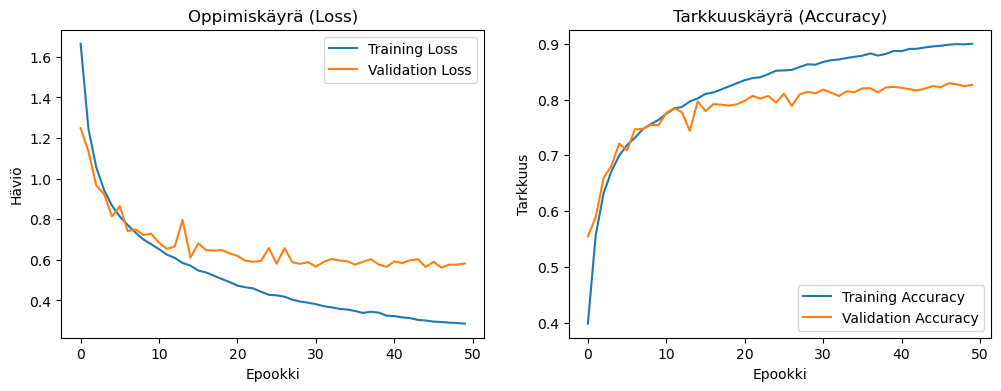

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Oppimiskäyrä (Loss)')
plt.xlabel('Epookki')
plt.ylabel('Häviö')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tarkkuuskäyrä (Accuracy)')
plt.xlabel('Epookki')
plt.ylabel('Tarkkuus')
plt.legend()
plt.show()

Example predictions with visuals

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


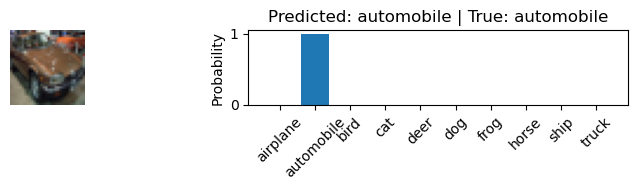

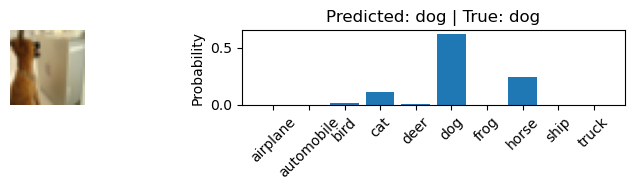

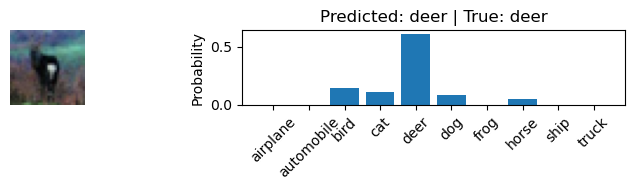

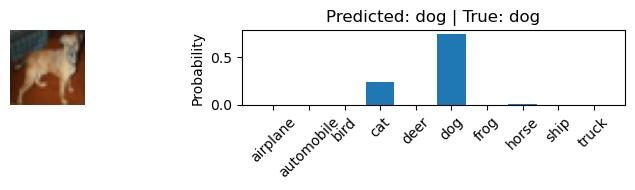

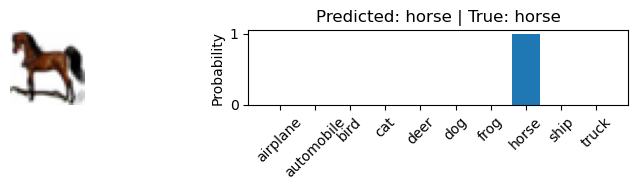

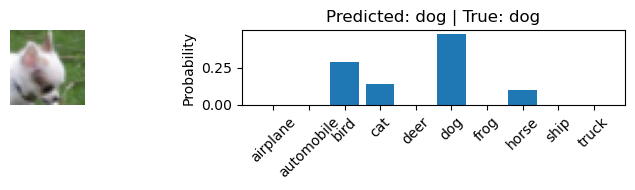

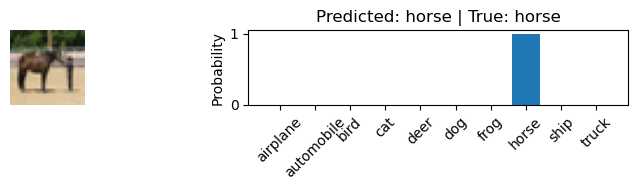

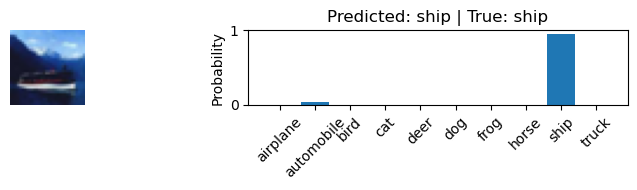

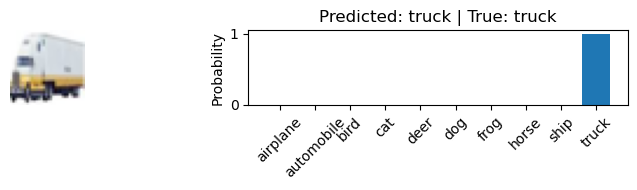

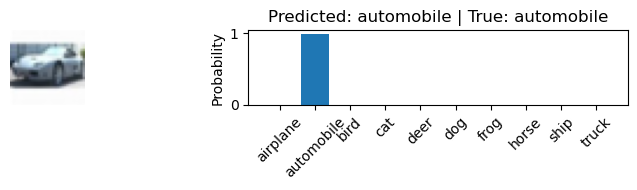

In [10]:
x = x_test
# This will process the data in batches of 32 (a standard size) to avoid memory leak
y_pred = model.predict(x_test, batch_size=32)
start = 2000

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

y_true = np.argmax(y_test, axis=1)

for k in range(10):
    plt.figure(figsize=(8, 2))

    # Kuva
    plt.subplot(1, 2, 1)
    plt.imshow(x[start + k])
    plt.axis('off')

    # Ennusteen todennäköisyydet
    plt.subplot(1, 2, 2)
    probs = y_pred[start + k].flatten()
    plt.bar(np.arange(10), probs)
    plt.xticks(np.arange(10), class_names, rotation=45)

    pred_label = class_names[np.argmax(probs)]
    true_label = class_names[y_true[start + k]]

    plt.ylabel("Probability")
    plt.title(f"Predicted: {pred_label} | True: {true_label}")

    plt.tight_layout()
    plt.show()